In [129]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from matplotlib.colors import ListedColormap

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [34]:
data_path = 'OV.methylation__humanmethylation450__jhu_usc_edu__Level_3__within_bioassay_data_set_function__data.data.txt'
df = pd.read_csv(data_path, sep='\t')

/var/folders/_g/ncq8t9cn3y97t4_nz1ds47c40000gn/T/ipykernel_13112/2888831559.py:2: DtypeWarning: Columns (1,4,5,8,9,12,13,16,17,20,21,24,25,28,29,32,33,36,37,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep='\t')


In [35]:
sample = df.columns # keep sample names

# changing structure of data frame
df.columns = df.iloc[0]
df = df.drop(0)
df = df.set_index(df.columns[0])

df.head()

,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,...,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate
Composite Element REF,,,,,,,,,,,,,,,,,,,,,
cg00000029,0.162232896986279,RBL2,16,53468112,0.191627667901702,RBL2,16,53468112,0.0712181967886229,RBL2,...,16,53468112,0.0681542463965581,RBL2,16,53468112,0.101053013486289,RBL2,16,53468112
cg00000108,NaN,C3orf35,3,37459206,NaN,C3orf35,3,37459206,NaN,C3orf35,...,3,37459206,NaN,C3orf35,3,37459206,NaN,C3orf35,3,37459206
cg00000109,NaN,FNDC3B,3,171916037,NaN,FNDC3B,3,171916037,NaN,FNDC3B,...,3,171916037,NaN,FNDC3B,3,171916037,NaN,FNDC3B,3,171916037
cg00000165,0.0774981107114241,NaN,1,91194674,0.539213127355674,NaN,1,91194674,0.0804679362519497,NaN,...,1,91194674,0.218775162768368,NaN,1,91194674,0.091250661927779,NaN,1,91194674
cg00000236,0.887426943347337,VDAC3,8,42263294,0.919352685107726,VDAC3,8,42263294,0.873067094340102,VDAC3,...,8,42263294,0.894063237620977,VDAC3,8,42263294,0.909250402621734,VDAC3,8,42263294


In [36]:
# check NaN value
df.isna().sum()

0
Beta_value             89725
Gene_Symbol           119717
Chromosome                65
Genomic_Coordinate         0
Beta_value             89725
Gene_Symbol           119717
Chromosome                65
Genomic_Coordinate         0
Beta_value             89709
Gene_Symbol           119717
Chromosome                65
Genomic_Coordinate         0
Beta_value             89747
Gene_Symbol           119717
Chromosome                65
Genomic_Coordinate         0
Beta_value             89723
Gene_Symbol           119717
Chromosome                65
Genomic_Coordinate         0
Beta_value             89772
Gene_Symbol           119717
Chromosome                65
Genomic_Coordinate         0
Beta_value             89710
Gene_Symbol           119717
Chromosome                65
Genomic_Coordinate         0
Beta_value             89761
Gene_Symbol           119717
Chromosome                65
Genomic_Coordinate         0
Beta_value             89715
Gene_Symbol           119717
Chromosome  

In [37]:
# Filtering genes with NaN values in Beta_value column
df = df.dropna(subset=['Beta_value'])
df.head()

,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,...,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate
Composite Element REF,,,,,,,,,,,,,,,,,,,,,
cg00000029,0.162232896986279,RBL2,16,53468112,0.191627667901702,RBL2,16,53468112,0.0712181967886229,RBL2,...,16,53468112,0.0681542463965581,RBL2,16,53468112,0.101053013486289,RBL2,16,53468112
cg00000165,0.0774981107114241,NaN,1,91194674,0.539213127355674,NaN,1,91194674,0.0804679362519497,NaN,...,1,91194674,0.218775162768368,NaN,1,91194674,0.091250661927779,NaN,1,91194674
cg00000236,0.887426943347337,VDAC3,8,42263294,0.919352685107726,VDAC3,8,42263294,0.873067094340102,VDAC3,...,8,42263294,0.894063237620977,VDAC3,8,42263294,0.909250402621734,VDAC3,8,42263294
cg00000289,0.70623334856886,ACTN1,14,69341139,0.585941172707428,ACTN1,14,69341139,0.53560092563212,ACTN1,...,14,69341139,0.45159368326575,ACTN1,14,69341139,0.718101311137447,ACTN1,14,69341139
cg00000292,0.600543186657216,ATP2A1,16,28890100,0.81526047238347,ATP2A1,16,28890100,0.340245216172717,ATP2A1,...,16,28890100,0.929602191814778,ATP2A1,16,28890100,0.637718731276499,ATP2A1,16,28890100


In [38]:
# Drop redundant Gene_symbol, Chromosome and Genomic_Coordinate columns

# Keep only the first occurrence of specific columns
columns_to_deduplicate = ['Chromosome', 'Gene_Symbol', 'Genomic_Coordinate']
df = df.loc[:, ~df.columns.duplicated(keep='first') | ~df.columns.isin(columns_to_deduplicate)]

# Check the updated DataFrame
df.head()

,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate,Beta_value,Beta_value,Beta_value,Beta_value,Beta_value,Beta_value,Beta_value,Beta_value,Beta_value
Composite Element REF,,,,,,,,,,,,,
cg00000029,0.162232896986279,RBL2,16,53468112,0.191627667901702,0.0712181967886229,0.0797617926225958,0.134907151266991,0.0541415985613948,0.0898579298345672,0.037865566345129,0.0681542463965581,0.101053013486289
cg00000165,0.0774981107114241,NaN,1,91194674,0.539213127355674,0.0804679362519497,0.116847394499493,0.240761474867287,0.0731841811860166,0.117232830385723,0.44386976357312,0.218775162768368,0.091250661927779
cg00000236,0.887426943347337,VDAC3,8,42263294,0.919352685107726,0.873067094340102,0.916907354805292,0.899778425612948,0.886990509454191,0.902827859783123,0.914979623404746,0.894063237620977,0.909250402621734
cg00000289,0.70623334856886,ACTN1,14,69341139,0.585941172707428,0.53560092563212,0.671885140457963,0.529425616903779,0.638185069667011,0.470522232834328,0.68323363569591,0.45159368326575,0.718101311137447
cg00000292,0.600543186657216,ATP2A1,16,28890100,0.81526047238347,0.340245216172717,0.846848323745542,0.793461162099088,0.394033633901396,0.457197228355476,0.920116383428113,0.929602191814778,0.637718731276499


In [39]:
# Extract only Beta_value columns
beta_value_columns = [index for index, column in enumerate(df.columns) if 'Beta_value' in column]
beta_values = df.iloc[:, beta_value_columns]

In [40]:
# Convert these values from string to float, calculate standard deviation and place it in the separate column
beta_values = beta_values.apply(pd.to_numeric, errors='coerce')
std_dev = beta_values.std(axis=1)
df['std_dev'] = std_dev

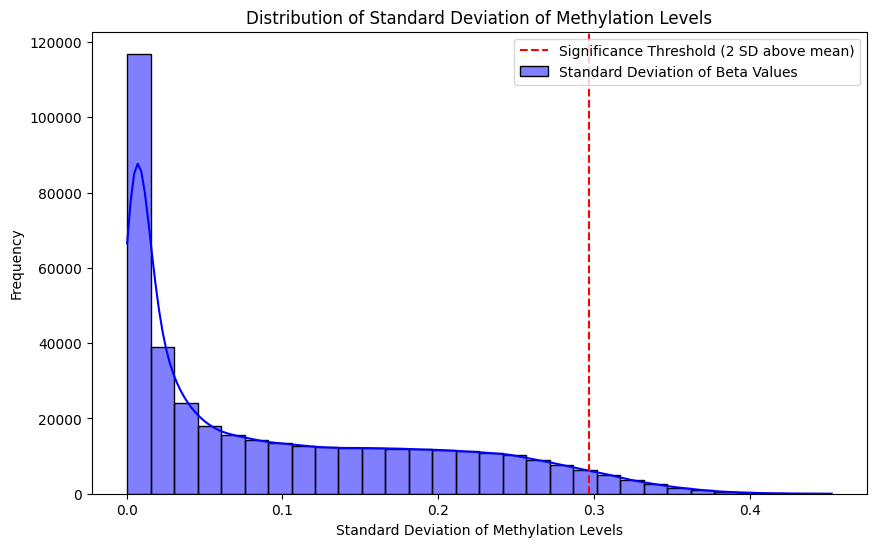

Threshold:  0.29687684557548
Number of significant methylation values: 16622


In [41]:
# Calculate the mean and standard deviation of the std_dev values
mean_std_dev = std_dev.mean()
std_dev_std_dev = std_dev.std()

# Set the threshold for significant methylation change (e.g., 2 standard deviations above the mean)
threshold = mean_std_dev + 2 * std_dev_std_dev

# Plot the histogram of standard deviations
plt.figure(figsize=(10, 6))
sns.histplot(std_dev, kde=True, color='blue', bins=30, label='Standard Deviation of Beta Values')

# Add a vertical line for the threshold
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Significance Threshold (2 SD above mean)')

# Add labels and title
plt.xlabel('Standard Deviation of Methylation Levels')
plt.ylabel('Frequency')
plt.title('Distribution of Standard Deviation of Methylation Levels')
plt.legend()

# Show the plot
plt.show()

significant = df[df['std_dev'] >= threshold]
print("Threshold: ", threshold)
print(f"Number of significant methylation values: {len(significant)}")

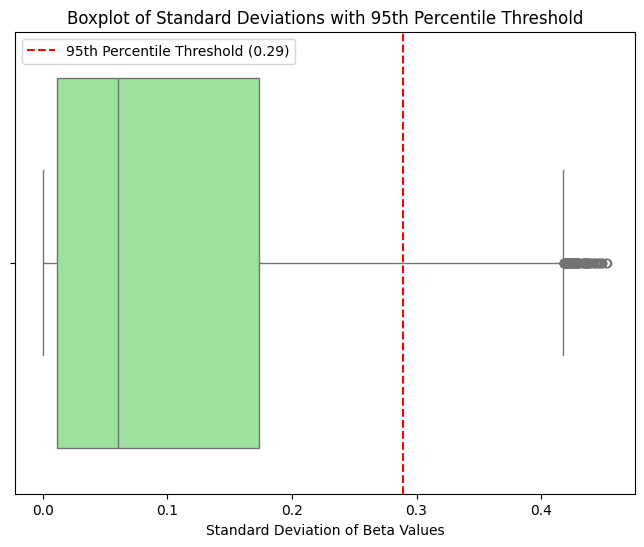

Percentile threshold:  0.2892595983816986
Number of significant methylation values: 19779


In [42]:
# Create a boxplot to visualize the distribution of the standard deviations of beta values
plt.figure(figsize=(8, 6))
sns.boxplot(data=std_dev, orient='h', color = 'lightgreen')

# Calculate the 95th percentile threshold
percentile_threshold = np.percentile(std_dev, 95)

# Overlay the threshold line
plt.axvline(x=percentile_threshold, color='red', linestyle='--', label=f'95th Percentile Threshold ({percentile_threshold:.2f})')

# Labels and title
plt.xlabel('Standard Deviation of Beta Values')
plt.title('Boxplot of Standard Deviations with 95th Percentile Threshold')
plt.legend()

# Show the plot
plt.show()

significant = df[df['std_dev'] >= percentile_threshold]
print("Percentile threshold: ", percentile_threshold)
print(f"Number of significant methylation values: {len(significant)}")

In [43]:
# Use mean value of obtained thresholds
threshold = (threshold + percentile_threshold) / 2

# Filter genes with significant variation in levels of methylation
df = df[df['std_dev'] >= threshold]
df = df.drop('std_dev', axis = 1)

print("Threshold: ", threshold)
print(f"Number of significant methylation values: {len(df)}")

Threshold:  0.2930682219785893
Number of significant methylation values: 18120


In [44]:
# Extract only Beta_value columns for filtered genes
beta_value_columns = [index for index, column in enumerate(df.columns) if 'Beta_value' in column]
beta_values = df.iloc[:, beta_value_columns]
beta_values = beta_values.apply(pd.to_numeric, errors='coerce')

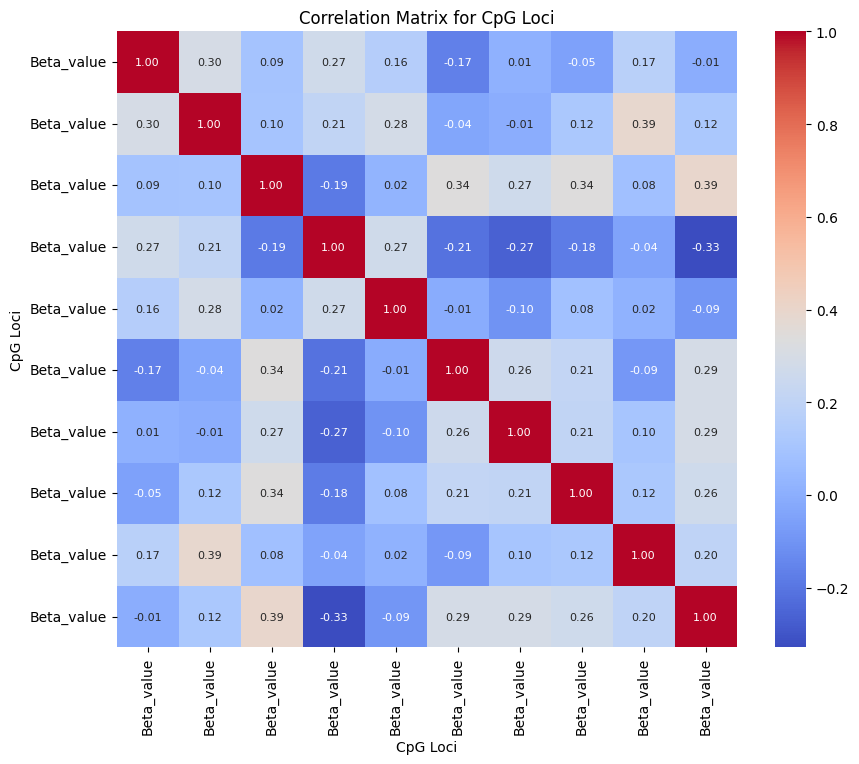

In [45]:
# Compute correlation matrix for CpG loci
correlation_matrix = beta_values.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", annot_kws={"size": 8})
plt.title('Correlation Matrix for CpG Loci')
plt.xlabel('CpG Loci')
plt.ylabel('CpG Loci')
plt.show()

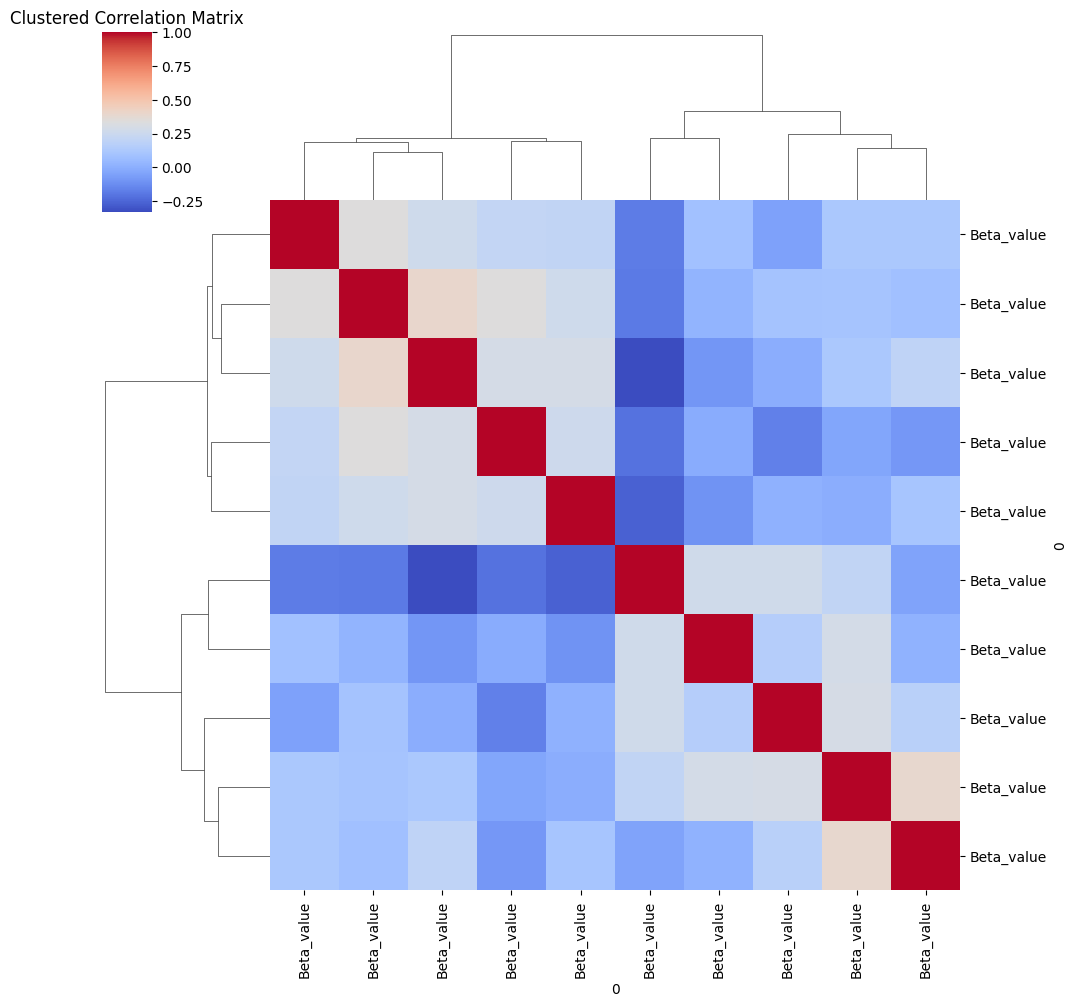

In [46]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Perform hierarchical clustering for better visualisation of correlations
linkage_matrix = linkage(correlation_matrix, method='ward')

# Plot a clustered heatmap
sns.clustermap(correlation_matrix, cmap='coolwarm', figsize=(10, 10), row_linkage=linkage_matrix, col_linkage=linkage_matrix)
plt.title('Clustered Correlation Matrix')
plt.show()

## Clustering by CpG loci

### KMeans

n_clusters: 2, Silhouette Score: 0.1888, Calinski Harabasz: 4175.5390, Davies-Bouldin: 2.0398
n_clusters: 3, Silhouette Score: 0.1724, Calinski Harabasz: 3538.9779, Davies-Bouldin: 1.9800
n_clusters: 4, Silhouette Score: 0.1478, Calinski Harabasz: 3090.4343, Davies-Bouldin: 1.8727
n_clusters: 5, Silhouette Score: 0.1357, Calinski Harabasz: 2638.9922, Davies-Bouldin: 1.9524
n_clusters: 6, Silhouette Score: 0.1357, Calinski Harabasz: 2457.9960, Davies-Bouldin: 1.8783
n_clusters: 7, Silhouette Score: 0.1388, Calinski Harabasz: 2299.5870, Davies-Bouldin: 1.9231
n_clusters: 8, Silhouette Score: 0.1315, Calinski Harabasz: 2116.3896, Davies-Bouldin: 1.9750
n_clusters: 9, Silhouette Score: 0.1364, Calinski Harabasz: 2030.0288, Davies-Bouldin: 1.9322
n_clusters: 10, Silhouette Score: 0.1173, Calinski Harabasz: 1895.7746, Davies-Bouldin: 1.9372
n_clusters: 11, Silhouette Score: 0.1440, Calinski Harabasz: 1862.5831, Davies-Bouldin: 1.8400
n_clusters: 12, Silhouette Score: 0.1331, Calinski Harabas

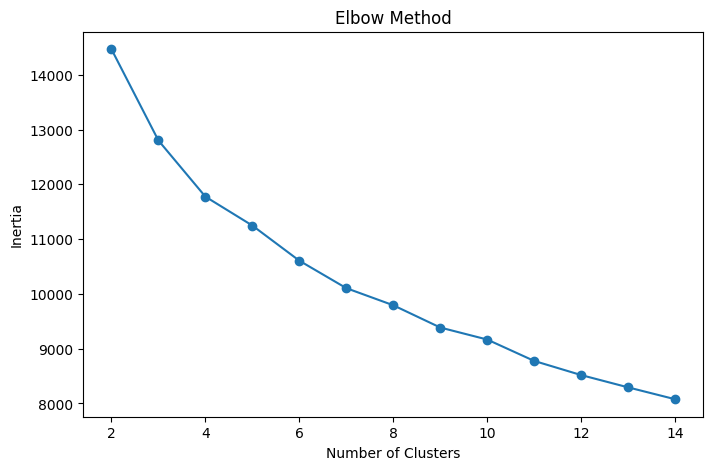


Best Results:
Best Silhouette Score: 0.1888 with parameters {'n_clusters': 2}
Best Calinski-Harabasz Score: 4175.5390 with parameters {'n_clusters': 2}
Best Davies-Bouldin Score: 1.7309 with parameters {'n_clusters': 14}


In [47]:
param_grid = {'n_clusters': range(2, 15)}

grid_search = ParameterGrid(param_grid)

# Initialize variables to store the best scores
best_silhouette_score = -1
best_calinski_harabasz_score = -1
best_davies_bouldin_score = float('inf')  # Lower is better
best_params_silhouette = None
best_params_calinski = None
best_params_davies = None

# Store results for the Elbow Method
inertia = []

for params in grid_search:
    kmeans = KMeans(n_clusters=params['n_clusters'], random_state=42)
    clusters = kmeans.fit_predict(beta_values)

    # Calculate metrics
    score_silhouette = silhouette_score(beta_values, clusters)
    score_calinski_harabasz = calinski_harabasz_score(beta_values, clusters)
    score_davies_bouldin = davies_bouldin_score(beta_values, clusters)
    inertia.append(kmeans.inertia_)  # Elbow Method
    
    print(f"n_clusters: {params['n_clusters']}, "
          f"Silhouette Score: {score_silhouette:.4f}, "
          f"Calinski Harabasz: {score_calinski_harabasz:.4f}, "
          f"Davies-Bouldin: {score_davies_bouldin:.4f}"
)

    # Update the best scores and parameters
    if score_silhouette > best_silhouette_score:
        best_silhouette_score = score_silhouette
        best_params_silhouette = params

    if score_calinski_harabasz > best_calinski_harabasz_score:
        best_calinski_harabasz_score = score_calinski_harabasz
        best_params_calinski = params

    if score_davies_bouldin < best_davies_bouldin_score:
        best_davies_bouldin_score = score_davies_bouldin
        best_params_davies = params


# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(2, 15), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Print the best results
print("\nBest Results:")
print(f"Best Silhouette Score: {best_silhouette_score:.4f} with parameters {best_params_silhouette}")
print(f"Best Calinski-Harabasz Score: {best_calinski_harabasz_score:.4f} with parameters {best_params_calinski}")
print(f"Best Davies-Bouldin Score: {best_davies_bouldin_score:.4f} with parameters {best_params_davies}")

In [48]:
# TODO: DBSCAN - Lazar

In [49]:
# TODO: Hijerarhijsko - Lana

In [50]:
# TODO: GMM - Lana

In [51]:
# TODO: Spektralno - Lazar

In [52]:
# Set the window size (16,330 base pairs)
window_size = 16330

# Ensure Genomic_Coordinate is numeric and sort data by chromosome and coordinate
df['Genomic_Coordinate'] = df['Genomic_Coordinate'].astype(int)
df_sorted = df.sort_values(by=['Chromosome', 'Genomic_Coordinate'])

# Assign each CpG locus to a window
df_sorted['Window'] = df_sorted['Genomic_Coordinate'] // window_size

# Group loci by window
grouped_windows = df_sorted.groupby(['Chromosome', 'Window'])

# Compute correlations and identify boundaries
window_mean_correlations = []

for (chromosome, window), group in grouped_windows:
    # Extract beta values for loci in this window
    beta_values_window = group.filter(like='Beta_value', axis=1)

    # Detect and exclude constant columns
    constant_columns = (beta_values_window.nunique() <= 1)
    if constant_columns.any():
        beta_values_window = beta_values_window.loc[:, ~constant_columns]
    
    # Compute mean correlation within the window
    if beta_values_window.shape[1] > 1:
        correlation_matrix = beta_values_window.corr()
        mean_correlation = correlation_matrix.stack().mean()
    else:
        mean_correlation = 0  # Single CpG in the window
    
    window_mean_correlations.append(mean_correlation)

# Detecting boundaries of region with sharp changes in methylation levels
threshold = np.percentile(window_mean_correlations, 95)
boundaries = [i for i, corr in enumerate(window_mean_correlations) if corr > threshold]

In [53]:
len(boundaries)

507

In [54]:
region_ranges = []

# Convert boundaries into region ranges
start = 0
for boundary in boundaries:
    region_ranges.append((start, boundary))
    start = boundary + 1
    
regions = []
for region in region_ranges:
    start, end = region
    region_data = df_sorted[(df_sorted['Window'] >= start) & (df_sorted['Window'] <= end)]
    mean_correlation = np.mean(window_mean_correlations[start:end + 1])
    
    # Append features for the region
    regions.append({
        'Mean_Correlation': mean_correlation
    })

# Create a DataFrame for clustering
regions_df = pd.DataFrame(regions)

In [55]:
regions_df.shape

(507, 1)

In [56]:
regions_df.head()

,Mean_Correlation
0,0.500000
1,0.221756
2,0.139747
3,0.778598
4,0.852149


## Region clustering

In [57]:
# TODO: KMeans - Lazar

### DBSCAN

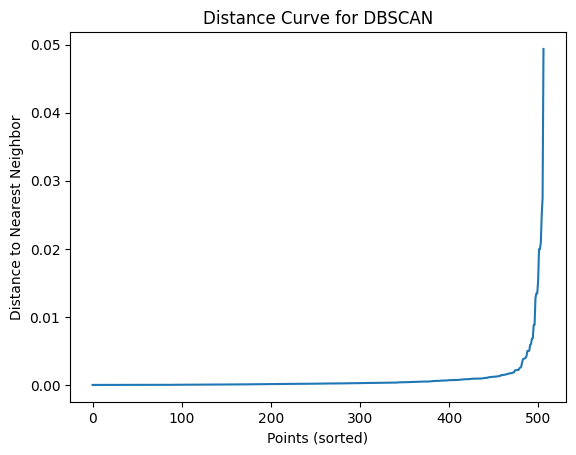

In [64]:
# Finding optimal eps using Distance Curve 
neigh = NearestNeighbors(n_neighbors=2)
neigh.fit(regions_df)
distances, _ = neigh.kneighbors(regions_df)
sorted_distances = np.sort(distances[:, 1]) 

# Visualising distance curve
import matplotlib.pyplot as plt
plt.plot(sorted_distances)
plt.title('Distance Curve for DBSCAN')
plt.xlabel('Points (sorted)')
plt.ylabel('Distance to Nearest Neighbor')
plt.show()

In [66]:
# Detect the elbow point
knee_locator = KneeLocator(range(len(sorted_distances)), sorted_distances, curve="convex", direction="increasing")
optimal_eps = sorted_distances[knee_locator.knee]

print(f"Optimal eps value: {optimal_eps:.4f}")

Optimal eps value: 0.0199


In [105]:
dbscan = DBSCAN(eps=optimal_eps, min_samples=5)
region_clusters = dbscan.fit_predict(regions_df)

unique_clusters = np.unique(region_clusters)
print(f'Number of clusters: {len(unique_clusters)}')

Number of clusters: 6


In [120]:
# Define a range of min_samples values to test
min_samples_range = range(3, 15)

# Track the best results for each metric
best_silhouette_score = -1
best_calinski_score = -1
best_davies_score = float('inf')  # Lower is better
best_params_silhouette = None
best_params_calinski = None
best_params_davies = None

for min_samples in min_samples_range:
    # Apply DBSCAN with fixed eps and varying min_samples
    dbscan = DBSCAN(eps=optimal_eps, min_samples=min_samples)
    labels = dbscan.fit_predict(regions_df)
    
    # Check if there are at least 2 clusters (otherwise metrics are invalid)
    if len(set(labels)) > 1:
        # Compute clustering metrics
        silhouette = silhouette_score(regions_df, labels)
        calinski = calinski_harabasz_score(regions_df, labels)
        davies = davies_bouldin_score(regions_df, labels)
        
        n_clusters = len(np.unique(labels))
        
        print(f"min_samples: {min_samples}, "
          f"Silhouette Score: {silhouette:.4f}, "
          f"Calinski Harabasz: {calinski:.4f}, "
          f"Davies-Bouldin: {davies:.4f}, "
          f"Number of Clusters: {n_clusters}"
)
        
        # Update best Silhouette Score
        if silhouette > best_silhouette_score:
            best_silhouette_score = silhouette
            best_params_silhouette = (min_samples, n_clusters)
        
        # Update best Calinski-Harabasz Index
        if calinski > best_calinski_score:
            best_calinski_score = calinski
            best_params_calinski = (min_samples, n_clusters)
        
        # Update best Davies-Bouldin Score
        if davies < best_davies_score:
            best_davies_score = davies
            best_params_davies = (min_samples, n_clusters)

# Print the best results for each metric
print()
print(f"Best Silhouette Score: {best_silhouette_score:.4f} at min_samples={best_params_silhouette[0]}. Number of clusters: {best_params_silhouette[1]}")
print(f"Best Calinski-Harabasz Index: {best_calinski_score:.4f} at min_samples={best_params_calinski[0]}. Number of clusters: {best_params_calinski[1]}")
print(f"Best Davies-Bouldin Score: {best_davies_score:.4f} at min_samples={best_params_davies[0]}. Number of clusters: {best_params_davies[1]}")


min_samples: 3, Silhouette Score: 0.8747, Calinski Harabasz: 1393.4885, Davies-Bouldin: 0.6966, Number of Clusters: 8
min_samples: 4, Silhouette Score: 0.8747, Calinski Harabasz: 1393.4885, Davies-Bouldin: 0.6966, Number of Clusters: 8
min_samples: 5, Silhouette Score: 0.8736, Calinski Harabasz: 1604.5939, Davies-Bouldin: 0.4877, Number of Clusters: 7
min_samples: 6, Silhouette Score: 0.8736, Calinski Harabasz: 1604.5939, Davies-Bouldin: 0.4877, Number of Clusters: 7
min_samples: 7, Silhouette Score: 0.8424, Calinski Harabasz: 1808.4171, Davies-Bouldin: 1.7584, Number of Clusters: 6
min_samples: 8, Silhouette Score: 0.8221, Calinski Harabasz: 2134.6540, Davies-Bouldin: 2.5310, Number of Clusters: 5
min_samples: 9, Silhouette Score: 0.8352, Calinski Harabasz: 2790.6173, Davies-Bouldin: 1.3287, Number of Clusters: 4
min_samples: 10, Silhouette Score: 0.8352, Calinski Harabasz: 2790.6173, Davies-Bouldin: 1.3287, Number of Clusters: 4
min_samples: 11, Silhouette Score: 0.9060, Calinski Har

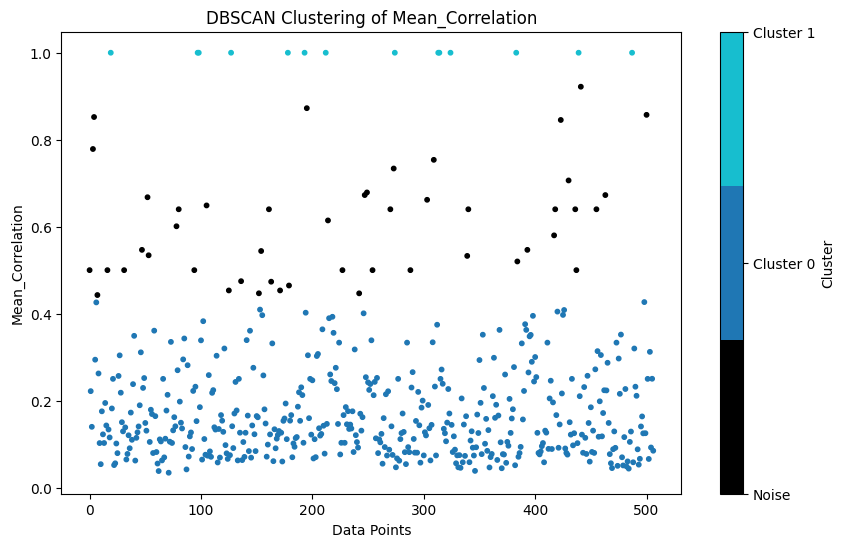

In [131]:
# Apply DBSCAN with the best parameters
dbscan = DBSCAN(eps=optimal_eps, min_samples=11)
clusters = dbscan.fit_predict(regions_df)
regions_df['Cluster'] = clusters

# Define a custom colormap where -1 (noise) is black and other clusters use high-contrast colors
unique_clusters = np.unique(clusters)
num_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
colors = plt.cm.tab10(np.linspace(0, 1, num_clusters))  # Use 'tab10' for better contrast
colors = np.vstack(([[0, 0, 0, 1]], colors))  # Add black color for noise
custom_cmap = ListedColormap(colors)

# Scatter plot for Mean_Correlation
plt.figure(figsize=(10, 6))
scatter = plt.scatter(range(len(regions_df)), 
                       regions_df['Mean_Correlation'], 
                       c=regions_df['Cluster'], 
                       cmap=custom_cmap, 
                       s=10)

# Customize the color bar to label -1 as "Noise"
cbar = plt.colorbar(scatter, ticks=np.arange(-1, num_clusters))
cbar.ax.set_yticklabels(['Noise'] + [f'Cluster {i}' for i in range(num_clusters)])
cbar.set_label('Cluster')

# Plot titles and labels
plt.title('DBSCAN Clustering of Mean_Correlation')
plt.xlabel('Data Points')
plt.ylabel('Mean_Correlation')
plt.show()

In [30]:
# TODO: Hijerehijsko - Lazar

In [31]:
# TODO: GMM - Lazar

In [32]:
# TODO: Spektrlno - Lana